In [1]:
!git clone -b torch_style_convs https://github.com/AntonioTepsich/Convolutional-KANs.git


Cloning into 'Convolutional-KANs'...
remote: Enumerating objects: 2277, done.
remote: Counting objects: 100% (307/307), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 2277 (delta 211), reused 233 (delta 154), pack-reused 1970 (from 1)
Receiving objects: 100% (2277/2277), 43.32 MiB | 15.64 MiB/s, done.
Resolving deltas: 100% (1231/1231), done.


In [2]:
%cd Convolutional-KANs/

/content/Convolutional-KANs


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from architectures_28x28.KKAN import *
from architectures_28x28.CKAN_BN import CKAN_BN
from architectures_28x28.KANConvs_MLP import *
from architectures_28x28.KANConvs_MLP_2 import *
from architectures_28x28.SimpleModels import *
from architectures_28x28.conv_and_kan import *

from evaluations import *
from generic_train import train_model_generic

In [5]:
%cd ..

/content


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Transformaciones
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Cargar MNIST y filtrar por dos clases
mnist_train = FashionMNIST(root='./data', train=True, download=True, transform=transform)

mnist_test = FashionMNIST(root='./data', train=False, download=True, transform=transform)

# DataLoader
train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

100%|██████████| 26.4M/26.4M [00:10<00:00, 2.41MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 212kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.93MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 19.6MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
path = "/content/drive/MyDrive/KANs/models/FashionMNIST_torchlike"
path_res = "/content/drive/MyDrive/KANs/results/FashionMNIST_torchlike"

# Evaluate models

In [8]:
device

device(type='cuda')

In [9]:
def join_path(name,pa):
  print(os.path.join(pa,name+".pt"))
  return os.path.join(pa,name+".pt")
models_listed = os.listdir(path)
import json



models = []

for m in models_listed:
    # Open and read the JSON file
    model = torch.load(os.path.join(path,m), map_location=torch.device(device))
    models.append(model)
    print(model.name)


<ipython-input-9-ff6bce4b2ceb>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(os.path.join(path,m), map_location=torch.device(device))


Conv & KAN (Medium) (gs = 10)
CNN  (Medium, but with more convs)
Conv & KAN (Medium) (gs = 20)
KKAN (Medium) (gs = 10)
KANC MLP (Small) (gs = 20)
KANC MLP (Big) (gs = 10)
Conv & KAN (Small) (gs = 10)
KANC MLP (Medium) (gs = 10)
CNN (Small)
KANC MLP (Small) (gs = 10)
KKAN (Small) (gs = 10)
KANC MLP (Medium) (gs = 20)
Conv & KAN (Small) (gs = 20)
CNN (Medium)
CNN (Big)
KKAN (Small) (gs = 20)
KANC MLP (Big) (gs = 20)
KKAN (Medium) (gs = 20)


In [10]:
criterion = nn.CrossEntropyLoss()


In [15]:


def highlight_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]


def final_plots(models, test_loader, criterion, device, use_time=False):
    accs = []
    precisions = []
    recalls = []
    f1s = []
    params_counts = []
    times = []
    tflops_per_sec = []
    contar = 0

    # Define color map and dictionary to store colors for models with "10" and "20" variants
    color_map = plt.get_cmap('tab20')(np.linspace(0, 1, len(models)))
    color_dict = {}
    fig, ax = plt.subplots(figsize=(12, 8))  # Increase figure size

    if use_time:
        with open(os.path.join(path_res, "epoch_times.json"), 'r') as file:
            times_dict = json.load(file)

    models_used = []
    models.sort(key=lambda x: x.name, reverse=False)

    for i, model in enumerate(models):

        # Test model and collect metrics
        test_loss, accuracy, precision, recall, f1 = test(model, device, test_loader, criterion)
        accs.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        params_counts.append(count_parameters(model))

        if use_time:
            times.append(times_dict.get(model.name, np.nan))
        else:
            times.append(np.nan)

        # Check for "10" or "20" in model names
        base_name = model.name.replace("10", "").replace("20", "")
        if base_name not in color_dict:
            color_dict[base_name] = color_map[i]  # Assign new color to this base model name

        # Select marker based on model name
        marker = 'x' if '10' in model.name else 'o' if '20' in model.name else 's'
        ax.scatter(count_parameters(model), accuracy*100, label=model.name, color=color_dict[base_name], marker=marker,s=65)

        models_used.append(model)
        contar += 1

    # Plot setup
    #ax.set_title("Number of Parameters vs Accuracy", fontsize=16)
    ax.set_xlabel("Number of Parameters", fontsize=12)
    ax.set_ylabel("Accuracy (%)", fontsize=12)
    legend = ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), fontsize=9, ncol=3)  # Set smaller font size and 3 columns
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Create DataFrame and export results
    df = pd.DataFrame({
        "Test Accuracy": accs,
        "Test Precision": precisions,
        "Test Recall": recalls,
        "Test F1 Score": f1s,
        "Number of Parameters": params_counts,
        "Seconds/epoch": times,
    }, index=[m.name for m in models_used])


    return df

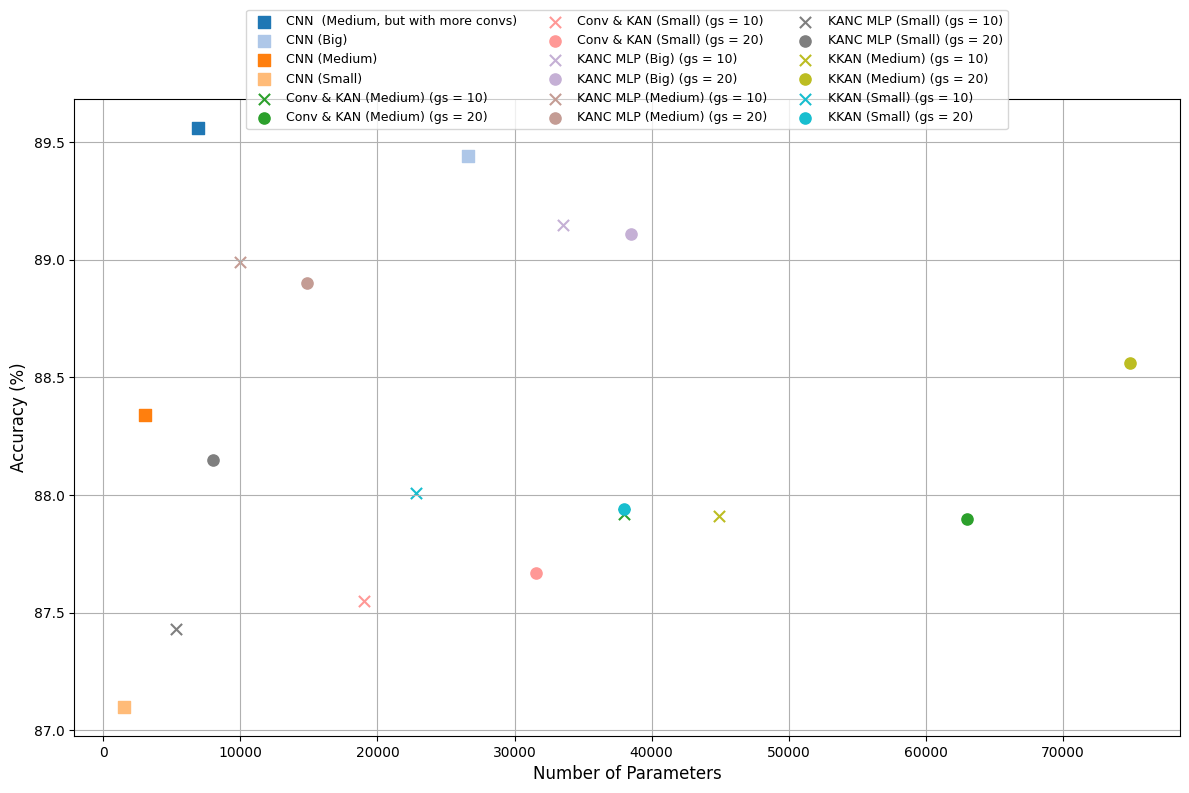

In [16]:
tabla = final_plots(models,test_loader,criterion,device,use_time = True)

In [13]:
tabla

,Test Accuracy,Test Precision,Test Recall,Test F1 Score,Number of Parameters,Seconds/epoch
"CNN (Medium, but with more convs)",0.8956,0.896023,0.8956,0.895525,6930,12.619682
CNN (Big),0.8944,0.894001,0.8944,0.893895,26620,12.681805
CNN (Medium),0.8834,0.881956,0.8834,0.882159,3020,12.617077
CNN (Small),0.8710,0.870822,0.8710,0.870091,1540,13.969206
Conv & KAN (Medium) (gs = 10),0.8792,0.878418,0.8792,0.878035,38010,13.838395
Conv & KAN (Medium) (gs = 20),0.8790,0.880789,0.8790,0.879483,63010,13.595402
Conv & KAN (Small) (gs = 10),0.8755,0.873701,0.8755,0.874222,19030,13.819559
Conv & KAN (Small) (gs = 20),0.8767,0.877424,0.8767,0.875915,31530,13.526114
KANC MLP (Big) (gs = 10),0.8915,0.892151,0.8915,0.891433,33535,99.136612
KANC MLP (Big) (gs = 20),0.8911,0.890554,0.8911,0.890560,38485,147.796222


In [27]:
latex_table = tabla.to_latex()

from IPython.display import display, Latex

display(Latex(f"```latex\n{latex_table}\n```"))

<IPython.core.display.Latex object>

In [30]:

def final_plots_espanol(models, test_loader, criterion, device, use_time=False):
    accs = []
    precisions = []
    recalls = []
    f1s = []
    params_counts = []
    times = []
    tflops_per_sec = []
    contar = 0

    # Define color map and dictionary to store colors for models with "10" and "20" variants
    color_map = plt.get_cmap('tab20')(np.linspace(0, 1, len(models)))
    color_dict = {}
    fig, ax = plt.subplots(figsize=(12, 8))  # Increase figure size

    if use_time:
        with open(os.path.join(path_res, "epoch_times.json"), 'r') as file:
            times_dict = json.load(file)

    models_used = []
    models.sort(key=lambda x: x.name, reverse=False)
    for i, model in enumerate(models):

        # Test model and collect metrics
        test_loss, accuracy, precision, recall, f1 = test(model, device, test_loader, criterion)
        accs.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        params_counts.append(count_parameters(model))

        if use_time:
            times.append(times_dict.get(model.name, np.nan))
        else:
            times.append(np.nan)

        # Check for "10" or "20" in model names
        base_name = model.name.replace("10", "").replace("20", "")
        if base_name not in color_dict:
            color_dict[base_name] = color_map[i]  # Assign new color to this base model name

        # Select marker based on model name
        marker = 'x' if '10' in model.name else 'o' if '20' in model.name else 's'
        ax.scatter(count_parameters(model), accuracy*100, label=model.name, color=color_dict[base_name], marker=marker,s=65)

        models_used.append(model)
        contar += 1

    # Plot setup
    #ax.set_title("Cantidad de parametros vs Accuracy", fontsize=16)
    ax.set_xlabel("Cantidad de parametros", fontsize=12)
    ax.set_ylabel("Accuracy (%)", fontsize=12)
    #legend = ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=8)  # Set smaller font size
    legend = ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), fontsize=9, ncol=3)  # Set smaller font size and 3 columns

    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Create DataFrame and export results
    df = pd.DataFrame({
        "Test Accuracy": accs,
        "Test Precision": precisions,
        "Test Recall": recalls,
        "Test F1 Score": f1s,
        "Number of Parameters": params_counts,
        "Seconds/epoch": times,
    }, index=[m.name for m in models_used])

    df.to_csv('experiment_28x28.csv', index=False)

    # Apply styling
    return df

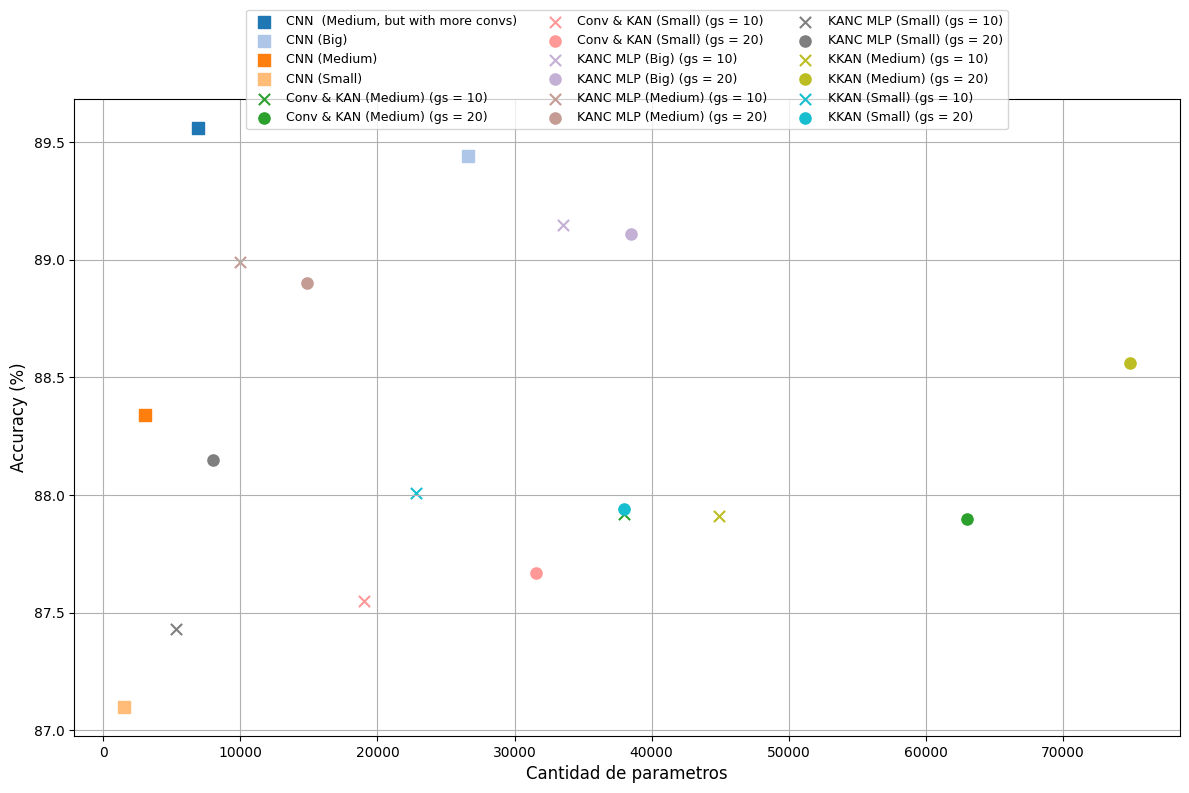

In [31]:
tabla = final_plots_espanol(models,test_loader,criterion,device,use_time = True)